# 1.加载需要的包

In [1]:
from __future__ import division
from __future__ import print_function

import argparse
import time

import numpy as np
import scipy.sparse as sp
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import sys

# 将特定路径加入到 Python 搜索路径中
sys.path.append('/root/autodl-tmp/.autodl/graph_link_prediction/graph_link_prediction_forfmri/GAE/gae-pytorch')

from gae.modelmulti import GCNModelVAE
from gae.optimizer import loss_function_batches
from gae.utils import load_and_save_data, mask_test_edges, preprocess_graph_batches, get_roc_score_batches,calculate_posweights_per_subject


# 2.设置参数

In [2]:


class Args:
    def __init__(self):
        # 定义默认参数
        self.model = 'gcn_vae'
        self.seed = 42
        self.epochs = 200
        self.hidden1 = 32
        self.hidden2 = 16
        self.lr = 0.01
        self.dropout = 0.0
        self.dataset_str = 'myUKB_FC'
        self.data_path = "/root/autodl-tmp/.autodl/data.npz"
# 创建实例
args = Args()

# 3. 运行代码

In [6]:
load_and_save_data("/root/autodl-tmp/.autodl/Y68p_FC_2_0.npy",threshold=0.5)

KeyboardInterrupt: 

In [3]:
# 打印当前使用的数据集名称
print("Using {} dataset".format(args.dataset_str))
# 加载图数据的邻接矩阵和特征矩阵
# 假设新的数据加载函数返回的是已划分的 adj_train, adj_val, adj_test, features 张量
data = np.load(args.data_path)
adj_train = data['adj_train']  # (train_p, n, n)
adj_val = data['adj_val']  # (val_p, n, n)
adj_test = data['adj_test']  # (test_p, n, n)
features = torch.FloatTensor(data['features'])  # (p, n, d), d=1 in this case
 # 获取节点数量和特征维度
n_nodes = adj_train.shape[1]
feat_dim = features.shape[2]
# 这里假设在训练时我们使用的是所有训练被试的邻接矩阵和特征
# 保存原始的训练邻接矩阵，用于后续的评估
adj_train_orig = torch.FloatTensor(adj_train)  # (train_p, n, n)


Using myUKB_FC dataset


## 3.1 看一下单个被试邻接矩阵的情况

<AxesSubplot:>

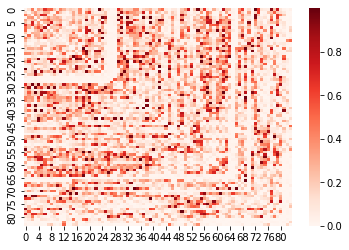

In [4]:
#sub1_adj=adj_train[1000,:,:]
#获得第一个维度平均值
sub1_adj=np.mean(adj_train,axis=0)
#绘制一个热力图
import seaborn as sns
import matplotlib.pyplot as plt
#用红色代表有连接，白色代表无连接
sns.heatmap(sub1_adj, cmap='Reds')

In [6]:
# 获取节点数量和特征维度
n_nodes = adj_train.shape[1]
feat_dim = features.shape[2]
# 这里假设在训练时我们使用的是所有训练被试的邻接矩阵和特征
# 保存原始的训练邻接矩阵，用于后续的评估
adj_train_orig = torch.FloatTensor(adj_train)  # (train_p, n, n)
# 设置训练集邻接矩阵为输入
adj_norm = preprocess_graph_batches(adj_train_orig)  # 对每个被试的邻接矩阵进行归一化
# 构造训练时的标签矩阵，包括自连接
#torch.eye是单位矩阵
#这段代码功能总结：
# 	•	为每个样本的邻接矩阵添加自连接（单位矩阵）。
# 	•	将结果转换为浮点张量类型，以便在后续的计算中使用。
# 这个过程在图神经网络（如 GCN、GAT 等）中很常见，因为添加自连接有助于节点在消息传递过程中能够获取到自身的信息。
adj_label = adj_train_orig + torch.eye(n_nodes).unsqueeze(0).repeat(adj_train_orig.shape[0], 1, 1)
adj_label = torch.FloatTensor(adj_label)  # 转换为 PyTorch 的张量
# 计算正样本的权重，用于在损失函数中平衡样本
# 代码功能总结
# •	pos_weight 用于处理类别不平衡，尤其是在存在边的数量远小于不存在边的数量的情况下，提升正样本（存在边）在损失函数中的权重。
# •	norm 用于标准化损失值，使得模型在训练时可以更加稳定，不受图大小或样本不平衡的影响。
# 这些参数通常在图神经网络的损失函数（如二元交叉熵）中使用，以便更好地训练图中稀疏连接的关系。
pos_weights, norms=calculate_posweights_per_subject(adj_train_orig)

# 初始化 GCN-VAE 模型，使用输入特征维度、隐藏层维度和 dropout 参数
model = GCNModelVAE(feat_dim, args.hidden1, args.hidden2, args.dropout)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
# 将训练集的特征和邻接矩阵标签转换为 TensorDataset，以便于 DataLoader 加载
# 假设 features 的维度是 (p, n, d)，adj_norm 和 adj_label 的维度是 (p, n, n)
train_features = features[:adj_train.shape[0]]  # 选择训练部分的特征
# 创建 TensorDataset
dataset = TensorDataset(train_features, adj_norm, adj_label)
batch_size = 32  # 定义 batch size，可以根据内存大小进行调整
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [7]:
adj_train_orig.sum()

tensor(41375680.)

In [8]:
# 设置早停的参数
patience = 5  # 允许验证分数连续下降的次数
best_val_score = float('-inf')  # 用于存储最佳验证分数
patience_counter = 0  # 记录连续验证分数未提升的次数

In [9]:
# 如果 adj_input 是 NumPy 数组，将其转换为 PyTorch 张量
if isinstance(adj_val, np.ndarray):
        adj_val = torch.FloatTensor(adj_val)

# 对输入邻接矩阵进行归一化处理
adj_val_norm = preprocess_graph_batches(adj_val)
# 构造标签矩阵，添加自连接
adj_val_label = adj_val + torch.eye(adj_val.shape[1]).unsqueeze(0).repeat(adj_val.shape[0], 1, 1)


In [10]:
# 如果 adj_input 是 NumPy 数组，将其转换为 PyTorch 张量
if isinstance(adj_test, np.ndarray):
        adj_test = torch.FloatTensor(adj_test)

# 对输入邻接矩阵进行归一化处理
adj_test_norm = preprocess_graph_batches(adj_test)
# 构造标签矩阵，添加自连接
adj_test_label = adj_test + torch.eye(adj_test.shape[1]).unsqueeze(0).repeat(adj_test.shape[0], 1, 1)
#adj_test_label得是0,1矩阵

In [11]:
from gae.utils import get_roc_score_batches_accelerated
def evaluate_model_on_data(model, features, adj_norm,adj_label,adj_orig):
    """
    对给定的输入邻接矩阵 adj_input 进行模型评估。
    :param model: 训练好的模型
    :param features: 输入的特征张量 (batch_size, n, feature_dim)
    :param adj_input: 被 mask 处理后的邻接矩阵，用于模型重建 (batch_size, n, n)
    :return: 每个被试的 ROC AUC 和 AP 分数列表
    """
    model.eval()  # 设置模型为评估模式

    with torch.no_grad():
        # 前向传播得到重构后的邻接矩阵 (recovered) 和潜在表示 (mu)
        recovered, mu, _ = model(features, adj_norm)
    
    # 使用潜在表示 (mu) 进行评估
    emb = mu.data.numpy()

    # 调用 get_roc_score 函数，自动从 adj_input 中生成正负样本边，并对每个被试计算 ROC 和 AP
    #对于rocscores以及apscores的计算方式，可以步入函数中去了解，有一个文档
    roc_scores, ap_scores = get_roc_score_batches_accelerated(emb, adj_orig.numpy())
    #这里必须用adj_orig.numpy()，因为adj_orig是0、1的。
    # 返回每个被试的 ROC AUC 和 AP 分数列表
    return roc_scores, ap_scores


In [12]:
from torch.utils.tensorboard import SummaryWriter
#设置时间戳
import time
import os
timestr = time.strftime("%Y%m%d-%H%M%S")
# 设置记录的路径
log_dir = "/root/autodl-tmp/.autodl/graph_link_prediction/graph_link_prediction_forfmri/GAE/gae-pytorch/gae/trainlog/" + timestr
#没有路径则创建
dir = os.path.dirname(log_dir)
if not os.path.exists(dir):
    os.makedirs(dir)
writer = SummaryWriter(log_dir=dir)
# 开始训练循环
for epoch in range(200):
    t = time.time()
    model.train()

    epoch_loss = 0  # 用于累计每一个epoch总损失
    for batch_idx, (batch_features, batch_adj_norm, batch_adj_label) in enumerate(dataloader):
            optimizer.zero_grad()

            # 前向传播，得到重构的邻接矩阵 (recovered) 和编码器输出的均值 (mu) 及对数方差 (logvar)
            # 在这里，我们输入的是每个批次的 features 和对应的 adj_norm
            recovered, mu, logvar = model(batch_features, batch_adj_norm)

            # 计算变分自编码器的损失，包括重构损失和 KL 散度
            loss = loss_function_batches(preds=recovered, labels=batch_adj_label,
                                     mu=mu, logvar=logvar, n_nodes=batch_adj_label.shape[1],
                                     norm=norm, pos_weight=pos_weight)
            loss.backward()
            optimizer.step()

            # 累加每个批次的损失
            epoch_loss += loss.item()
            # 每隔一定的步骤，记录一次loss
            # 记录每个批次的损失
            writer.add_scalar('training_loss', loss.item(), epoch * len(batch_idx) + i)
    # 打印当前 epoch 的平均训练损失
    avg_epoch_loss = epoch_loss / len(dataloader)
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_epoch_loss),
          "time=", "{:.5f}".format(time.time() - t))
    #验证集记录损失函数
    model.eval()  # 切换到评估模式
    with torch.no_grad():
        recovered_val, mu_val, logvar_val = model(features[adj_train.shape[0]:adj_train.shape[0] + adj_val.shape[0]],adj_val_norm)
        val_loss = loss_function_batches(
            preds=val_preds,
            labels=adj_val_label,
            mu=mu_val,  # 如果需要计算 KL 散度
            logvar=logvar_val,  # 如果需要计算 KL 散度
            n_nodes=adj_val_label.shape[1],
            norm=norm,
            pos_weight=pos_weight
        )

    # 打印并记录验证集的损失
    print(f"Epoch {epoch}, Validation Loss: {val_loss.item():.5f}")
    writer.add_scalar('validation/loss', val_loss.item(), epoch)

    # 恢复训练模式
    model.train()
    # 验证集评估
    val_roc_scores, val_ap_scores = evaluate_model_on_data(
        model,
    features[adj_train.shape[0]:adj_train.shape[0] + adj_val.shape[0]],
        adj_val_norm,adj_val_label,adj_val)
    # 计算均值
    val_avg_roc_score = np.mean(val_roc_scores)
    val_avg_ap_score = np.mean(val_ap_scores)
    print("val_roc=", "{:.5f}".format(val_avg_roc_score), "val_ap=", "{:.5f}".format(val_avg_ap_score))
    # 记录到TensorBoard
    writer.add_scalar('validation/val_roc', val_avg_roc_score, epoch)
    writer.add_scalar('validation/val_ap', val_avg_ap_score, epoch)
    
    # 早停逻辑：检查当前验证分数是否为最佳
    if val_avg_roc_score > best_val_score:
        best_val_score = val_avg_roc_score
        patience_counter = 0  # 重置计数器
    else:
        patience_counter += 1  # 增加计数器
        print(f"Early stopping counter: {patience_counter}/{patience}")
        # 如果计数器达到patience，则停止训练
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
print("Optimization Finished!")

# 测试集评估
test_roc_scores, test_ap_scores = evaluate_model_on_data(model, features[ adj_val.shape[0]: adj_val.shape[0]+adj_test.shape[0]] , adj_test_norm, adj_test_label,adj_test)
# 计算均值
test_avg_roc_score = np.mean(test_roc_scores)
test_avg_ap_score = np.mean(test_ap_scores)
print('Test ROC score: ' + str(test_avg_roc_score))
print('Test AP score: ' + str(test_avg_ap_score))


ModuleNotFoundError: No module named 'past'